In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
from models.efficientnet_pytorch_3d import EfficientNet3D as EfNetB0
from src.data_module import MyDataModule
from torch.utils.data import DataLoader
from src.modules import ModuleTrainer
from src.callbacks import ModelCheckpoint, CSVLogger, CyclicLR
from src.metrics import MSE, MAE
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def MAE_pred(y_pred, y_true):
    mae = nn.L1Loss(reduction='mean')(y_pred, y_true).cpu().detach().numpy().item()
    return mae
def MSE_pred(y_pred, y_true):
    mse = nn.MSELoss()(y_pred, y_true).cpu().detach().numpy().item()
    return mse
def delta_pred(y_pred, y_true):
    delta = y_pred - y_true
    return np.mean(delta)

In [3]:
def ensemble(left, right):
    right = right[['Name', 'Pred']]
    ensemble = pd.merge(left, right, on=['Name'], suffixes=("_L", "_R"))
    ensemble['Pred'] = ensemble.apply(lambda x: (x['Pred_L']+x['Pred_R'])/2, axis=1)
    return ensemble

In [4]:
def metrics(preds):
    print("MAE", MAE_pred(torch.from_numpy(preds['Pred'].values), torch.from_numpy(preds['True'].values)))
    print("MSE", MSE_pred(torch.from_numpy(preds['Pred'].values), torch.from_numpy(preds['True'].values)))
    print("Delta", delta_pred(preds['Pred'], preds['True']))

In [5]:
def plot_regression(x, y):
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    # intercept = 0
    # slope = 1
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='s', label='Data points')
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel('Chronological age')
    ax.set_ylabel('Estimated age')
    ax.legend(facecolor='white')
    plt.show()

In [6]:
def bias_corr(pred):
    a = 0.41
    b = 45.42
    return pd.Series((pred - b)/a)

Left
MAE 5.794213662162161
MSE 63.312904816202014
Delta 1.373053689189189


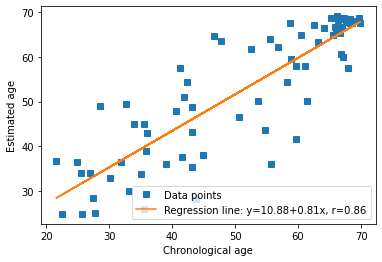

Right
MAE 4.556885905405406
MSE 38.98392953925121
Delta 0.4433662027027024


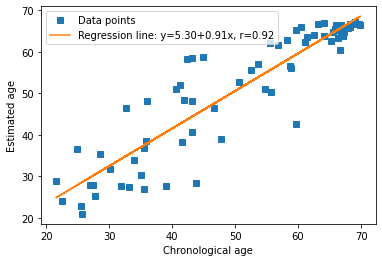

Left+Right
MAE 4.365261635135134
MSE 37.649630152610996
Delta 0.9082099459459453


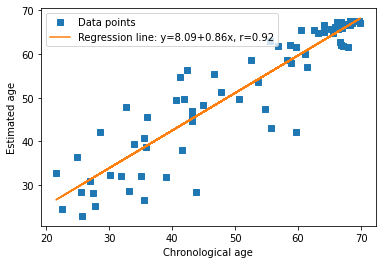

In [7]:
# Validation 0-70
val_L = pd.read_csv("predict_results/val_0-70_L.csv")
val_R = pd.read_csv("predict_results/val_0-70_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/val_0-70_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L['True'], val_L['Pred'])
print("Right")
metrics(val_R)
plot_regression(val_R['True'], val_R['Pred'])
print("Left+Right")
metrics(ens)
plot_regression(ens['True'], ens['Pred'])

Left
MAE 3.92842898013245
MSE 25.579362089656264
Delta 0.9215553907284763


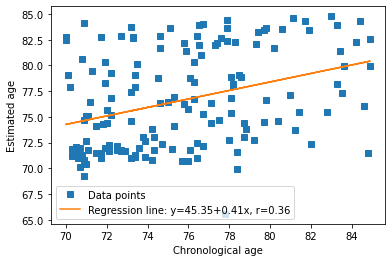

Right
MAE 3.5481887284768217
MSE 21.35378393995642
Delta -1.1338471125827818


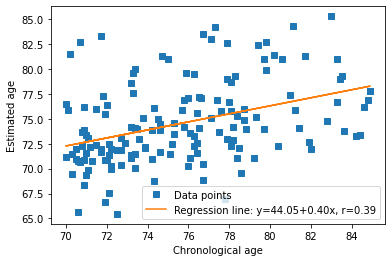

Left+Right
MAE 3.3587705231788076
MSE 17.94599709666341
Delta -0.1061458609271526


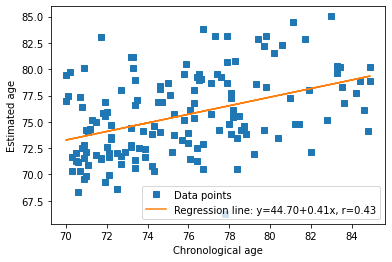

In [8]:
# Validation 70-100
val_L = pd.read_csv("predict_results/val_exp_L.csv")
val_R = pd.read_csv("predict_results/val_exp_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/val_exp_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L['True'], val_L['Pred'])
print("Right")
metrics(val_R)
plot_regression(val_R['True'], val_R['Pred'])
print("Left+Right")
metrics(ens)
plot_regression(ens['True'], ens['Pred'])

Left
MAE 4.477334695364239
MSE 30.201664425782905
Delta 1.0984416225165567


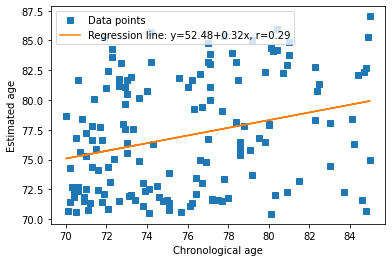

Right
MAE 3.692468516556291
MSE 22.78966583112645
Delta -1.5773569536423828


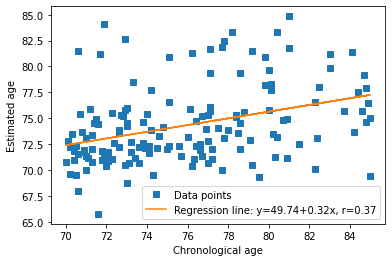

Left+Right
MAE 3.509057533112582
MSE 19.08811899573441
Delta -0.23945766556291279


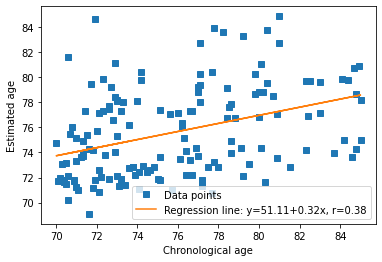

Min 70.0 / 69.09328500000001 Max 85.0 / 84.881268


In [9]:
# Test 0-70
val_L = pd.read_csv("predict_results/test_exp_L.csv")
val_R = pd.read_csv("predict_results/test_exp_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/test_exp_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L['True'], val_L['Pred'])
print("Right")
metrics(val_R)
plot_regression(val_R['True'], val_R['Pred'])
print("Left+Right")
metrics(ens)
plot_regression(ens['True'], ens['Pred'])
print("Min", ens['True'].min(), "/", ens['Pred'].min(),
      "Max", ens['True'].max(), "/", ens['Pred'].max())

Left
MAE 5.699224411483253
MSE 48.25934204873231
Delta 4.396512382775119


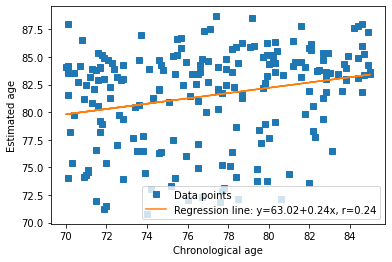

Right
MAE 4.559458516746411
MSE 31.09246814015029
Delta 2.3196649473684214


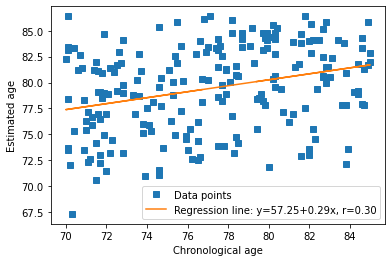

Left+Right
MAE 4.658749363636364
MSE 33.87118613280338
Delta 3.35808866507177


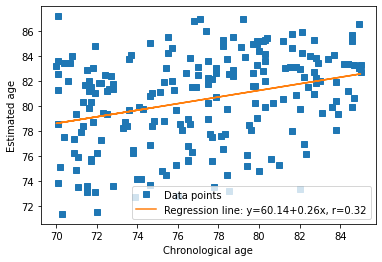

In [11]:
# AD
val_L = pd.read_csv("predict_results/ad_images_L.csv")
val_R = pd.read_csv("predict_results/ad_images_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/ad_images_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L['True'], val_L['Pred'])
print("Right")
metrics(val_R)
plot_regression(val_R['True'], val_R['Pred'])
print("Left+Right")
metrics(ens)
plot_regression(ens['True'], ens['Pred'])

Min 70.0 / 71.357012 Max 85.0 / 87.16823


(69.0, 91.0)

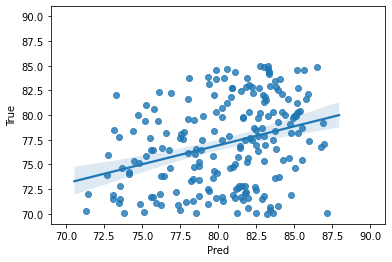

In [12]:
print("Min", ens['True'].min(), "/", ens['Pred'].min(),
      "Max", ens['True'].max(), "/", ens['Pred'].max())
ax = sns.regplot(x="Pred", y="True", data=ens)
ax.set_xlim(69, 91)
ax.set_ylim(69, 91)

Left
MAE 5.243145494023905
MSE 43.62505732102133
Delta 3.5850374701195213


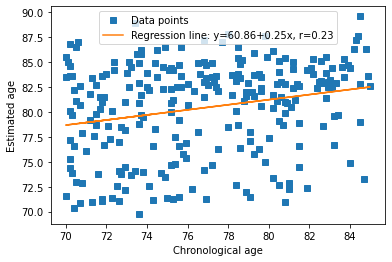

Right
MAE 4.732870047808764
MSE 35.336369029477055
Delta 1.4572912828685256


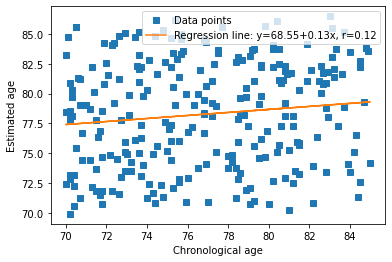

Left+Right
MAE 4.511778484063745
MSE 32.11629277516686
Delta 2.5211643764940237


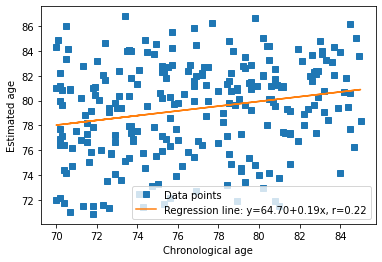

Min 70.0 / 70.88492500000001 Max 85.0 / 86.78855250000001


In [13]:
# MCI
val_L = pd.read_csv("predict_results/mci_images_L.csv")
val_R = pd.read_csv("predict_results/mci_images_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/mci_images_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L['True'], val_L['Pred'])
print("Right")
metrics(val_R)
plot_regression(val_R['True'], val_R['Pred'])
print("Left+Right")
metrics(ens)
plot_regression(ens['True'], ens['Pred'])
print("Min", ens['True'].min(), "/", ens['Pred'].min(),
      "Max", ens['True'].max(), "/", ens['Pred'].max())